<a href="https://colab.research.google.com/github/yuma-yuma1/dqn-quiita/blob/main/dqn_qiita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#必要なライブラリのインポート
!pip install gym
!pip install torch
!pip install numpy
!pip install matplotlib
!pip install random

ERROR: Could not find a version that satisfies the requirement random (from versions: none)
ERROR: No matching distribution found for random


次に必要なパラメータの設定

In [ ]:
import gym
import math
import random
import numpy as np
from collections import deque
import torch
from torch import nn
import torch.nn.functional as F

GAMMA = 0.95                            #割引率
LEARNING_RATE = 0.001                   #学習率
MEMORY_SIZE = 1000000                   #リプレイバッファのサイズ。過去の経験を保存するための最大容量
BATCH_SIZE = 64                        #学習時に一度にサンプリングするデータ数
EPS_START = 1.0                        #ε-greedy法におけるεの初期値、
EPS_END = 0.05                         #ε-greedy法におけるεの最終値、
EPS_DECAY = 1000                       #ε-greedy法におけるεの減衰率
TOTAL_TS = 10000                       #全体のステップ数
SYNC_FREQ = 10                         #ターゲットネットワークを同期させる頻度
seed = 2023                            #乱数シード

#乱数シードの設定
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)



In [ ]:
#リプレイバッファの定義(状態、行動、報酬、次の状態など)
class ReplayBuffer(object):
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = []
        self.index = 0

#バッファに新しい経験を追加。バッファが満杯の場合は古い経験を上書き
    def append(self, obj):
        if self.size() > self.buffer_size:
            print('buffer size larger than set value, trimming...')
            self.buffer = self.buffer[(self.size() - self.buffer_size):]
        elif self.size() == self.buffer_size:
            self.buffer[self.index] = obj
            self.index += 1
            self.index %= self.buffer_size
        else:
            self.buffer.append(obj)

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size, device="cpu"):#バッファからランダムにサンプリングし学習のために返す
        if self.size() < batch_size:
            batch = random.sample(self.buffer, self.size())
        else:
            batch = random.sample(self.buffer, batch_size)

        res = []
        for i in range(5):
            k = np.stack(tuple(item[i] for item in batch), axis=0)
            res.append(torch.tensor(k, device=device))
        return res[0], res[1], res[2], res[3], res[4]


In [ ]:
device = "cuda" # "cpu"
env = gym.make("CartPole-v1")
n_observations = env.observation_space.shape[0]#状態の次元数
n_actions = env.action_space.n #可能な行動の数
buffer = ReplayBuffer(buffer_size=MEMORY_SIZE)
main_net = nn.Sequential(
    nn.Linear(n_observations, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, n_actions)
)
criterion = nn.MSELoss()
optimiser = torch.optim.Adam(main_net.parameters())

from copy import deepcopy
target_net = deepcopy(main_net)


In [ ]:
num_episode = global_ts = 0
ep_rewards = list()
while global_ts <= TOTAL_TS:
    state, done = env.reset(), False
    ep_reward, ep_ts = 0.0, 0
    while not done:
        eps = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * global_ts / EPS_DECAY)
        if np.random.rand() < eps:
            action = np.random.choice(n_actions)
        else:
            with torch.no_grad():
                q = main_net(torch.tensor(state[None, :])).detach().cpu().numpy()
            action = np.argmax(q[0])

        next_state, reward, done, info = env.step(action)
        ep_reward += reward
        reward = reward if not done else -reward
        buffer.append((state, action, reward, next_state, done))
        state = next_state
        if done:
            ep_rewards.append(ep_reward)
            if (num_episode == 0) or ((num_episode + 1) % 50 == 0):
                print(f"Ep-{num_episode + 1} {global_ts + 1}/{TOTAL_TS} Eps: {eps:.2f}, Reward: {ep_reward}")
            break

        if buffer.size() >= BATCH_SIZE:
            obses_t, actions, rewards, obses_tp1, dones = buffer.sample(BATCH_SIZE)
            # Optimize the model
            with torch.no_grad():
                target_q = target_net(obses_tp1).detach().max(1)[0]
            target = rewards + GAMMA * target_q * (1 - dones.float())
            val_t = main_net(obses_t).gather(1, actions.unsqueeze(1)).squeeze(1)
            loss = F.mse_loss(val_t.float(), target.float())
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            # Periodically sync the target and main networks
            if (global_ts + 1) % SYNC_FREQ == 0:
                target_net.load_state_dict(main_net.state_dict())
        ep_ts += 1
        global_ts += 1
    num_episode += 1


Ep-1 13/10000 Eps: 0.99, Reward: 13.0
Ep-50 5061/10000 Eps: 0.06, Reward: 156.0


Text(0, 0.5, 'Ep-Return')

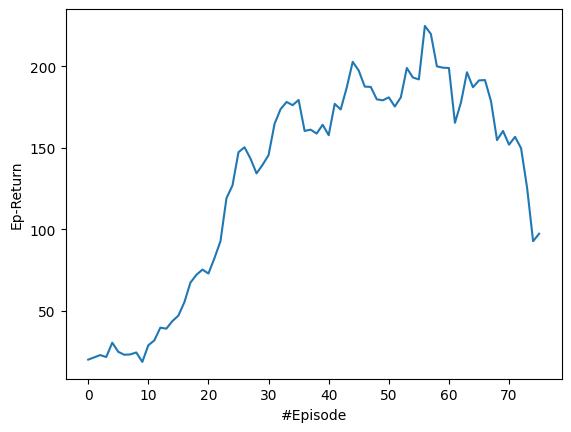

In [ ]:
import matplotlib.pyplot as plt

def moving_average(a, n=5) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.plot(moving_average(ep_rewards))
plt.xlabel("#Episode")
plt.ylabel("Ep-Return")
